# Amazon Review Data

We use this layout for embedding (apart from I am using the 4th Universal Sentence Encoder, rather than 3rd) and our neural network: https://www.curiousily.com/posts/sentiment-analysis-with-tensorflow-2-and-keras-using-python/ - the work of 
Venelin Valkov. I am also doing this for three category classification rather than 2. 

Import necessary packages:

In [ ]:
!pip install tensorflow_text
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow_hub as hub
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
RANDOM_STATE = 38
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

     |████████████████████████████████| 2.6MB 3.5MB/s 
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


This is a huge csv file of Amazon reviews taken from kaggle: https://www.kaggle.com/snap/amazon-fine-food-reviews 

In [ ]:
df = pd.read_csv("drive/My Drive/csv's/Amazon_Reviews.csv",engine='python')
print(df)
df['Score'].value_counts()

            Id  ...                                               Text
0            1  ...  I have bought several of the Vitality canned d...
1            2  ...  Product arrived labeled as Jumbo Salted Peanut...
2            3  ...  This is a confection that has been around a fe...
3            4  ...  If you are looking for the secret ingredient i...
4            5  ...  Great taffy at a great price.  There was a wid...
...        ...  ...                                                ...
568449  568450  ...  Great for sesame chicken..this is a good if no...
568450  568451  ...  I'm disappointed with the flavor. The chocolat...
568451  568452  ...  These stars are small, so you can give 10-15 o...
568452  568453  ...  These are the BEST treats for training and rew...
568453  568454  ...  I am very satisfied ,product is as advertised,...

[568454 rows x 10 columns]


5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

# Preprocessing 

Converting scores:   

*   0 : Negative
*   1 : Average
*   2 : Positive





In [ ]:
df['review_type'] = df['Score']
df.loc[df['review_type'] == 1, 'review_type'] = 0
df.loc[df['review_type'] == 2, 'review_type'] = 0
df.loc[df['review_type'] == 3, 'review_type'] = 1
df.loc[df['review_type'] == 4, 'review_type'] = 2
df.loc[df['review_type'] == 5, 'review_type'] = 2

print(df.head)

<bound method NDFrame.head of             Id  ... review_type
0            1  ...           2
1            2  ...           0
2            3  ...           2
3            4  ...           0
4            5  ...           2
...        ...  ...         ...
568449  568450  ...           2
568450  568451  ...           0
568451  568452  ...           2
568452  568453  ...           2
568453  568454  ...           2

[568454 rows x 11 columns]>


From this average_reviews has the least number of reviews, so make each category the same size:

In [ ]:
negative_reviews = df[df.review_type == 0]
average_reviews = df[df.review_type == 1]
positive_reviews = df[df.review_type == 2]

print(negative_reviews.shape)
print(average_reviews.shape)
print(positive_reviews.shape)

(82037, 11)
(42640, 11)
(443777, 11)


Set the 3 dataframes to be the same length as the length of average and then append these reviews to a new dataframe, review_df:

In [ ]:
negative_df = negative_reviews.sample(n=len(average_reviews), random_state=RANDOM_STATE)
average_df = average_reviews
positive_df = positive_reviews.sample(n=len(average_reviews), random_state=RANDOM_STATE)
review_df = negative_df.append(average_df).append(positive_df)

print(negative_df.shape)
print(average_df.shape)
print(positive_df.shape)
print(review_df)

(42640, 11)
(42640, 11)
(42640, 11)
            Id  ... review_type
283904  283905  ...           0
529413  529414  ...           0
70552    70553  ...           0
338931  338932  ...           0
100498  100499  ...           0
...        ...  ...         ...
454975  454976  ...           2
19141    19142  ...           2
60391    60392  ...           2
264479  264480  ...           2
156661  156662  ...           2

[127920 rows x 11 columns]


Now have the same number of reviews for each category:

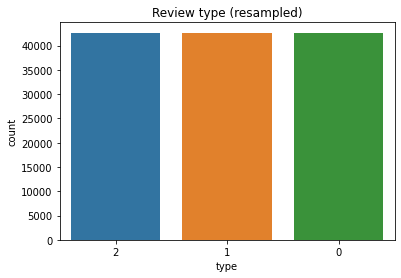

In [ ]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

Load the Universal Sentence Encoder: Instead of doing lots of preprocessing, tokenizing etc, thus we use the Universal Sentence Encoder to encode sentences into embedding vectors. This is basically a way of comparing sentences after converting them to a vector of 512 elements. 

In [ ]:
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

We one-hot encode the review types, i.e. puts 1 or 0 in place of positive, negative or average. 

In [ ]:
type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

Split the data into: train_reviews, test_reviews, y_train, y_test, so that embeddings can be created:

In [ ]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.Text, 
    type_one_hot, 
    test_size=.1, 
    random_state=RANDOM_STATE
  )

Check what train_reviews looks like and its shape. 

In [ ]:
print(train_reviews)
print(train_reviews.shape)

403603    I was nervous to order a sampler after reading...
231401    I don't normally write reviews but for Orgain ...
423055    This item sold and shipped by [...] is nothing...
340894    I got these for a bbq we were having for a mak...
139251    My family and I are slowly making changes to e...
                                ...                        
359982    Okay, I'll admit, I do want to be the only thr...
488411    I purchased a single serve coffee maker that u...
112140    My cats love "wild" foods. I had been getting ...
248732    This Goji powder, I don't know... I feel like ...
467603    The first cake that arrived was so dry and som...
Name: Text, Length: 115128, dtype: object
(115128,)


Create embeddings for X_train, note that this is for the 4th USE so need to use [ r ] rather than r:

In [ ]:
X_train = []
for r in tqdm(train_reviews):
  emb = use([r])
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 115128/115128 [10:40<00:00, 179.65it/s]


Create Embeddings for X_test:

In [ ]:
X_test = []
for r in tqdm(test_reviews):
  emb = use([r])
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 12792/12792 [01:11<00:00, 179.89it/s]


Saving the embeddings for X_train because this takes a while to do

In [ ]:
train_out = open("train.pickle_3","wb")
pickle.dump(X_train, train_out)
train_out.close()

Saving the embeddings for X_test 

In [ ]:
test_out = open("test.pickle_3","wb")
pickle.dump(X_test, test_out)
test_out.close()

Loading in X_train and X_test:

In [ ]:
pickle_in3 = open("drive/My Drive/train.pickle_3","rb")
X_train = pickle.load(pickle_in3)
pickle_in4 = open("drive/My Drive/test.pickle_3","rb")
X_test = pickle.load(pickle_in4)

Now X_train is made up of 115,128 lots of vectors of length 512:

In [ ]:
print(X_train.shape, X_test.shape)

(115128, 512) (12792, 512)


In [ ]:
X_train[0].shape

(512,)

# Sentiment Analysis

*   **Input layer:** Start with the fully connected layer, with 256 neurons, input shape is the same shape as X_train, i.e. 512. Use reLu activation function.  
*   **2nd layer:** Dropout layer (prevent overfitting)
*   **3rd layer:** Same as input layer, but with 128 neurons (half). 
*   **4th layer:** Dropout layer
*   **Output layer:** Outputs 3 neurons for negative, average and positive. Softmax activation as we are doing classification 

In [ ]:
model = keras.Sequential()

model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)

model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 164,611
Trainable params: 164,611
Non-trainable params: 0
_________________________________________________________________


The model runs for as many epochs necessary before the val_loss starts to rise (it gets to around 27 epochs). The model achieves higher accuracy at batch_size 32 than other batch sizes. Note this uses a validation split of 0.1, rather than 0.2 in the Metacritic model, because it has so much data to work with. This achieves around 76% accuracy on the training data and 74% on the validation data. 

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train, y_train, 
    callbacks=[es_callback],
    epochs=100, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/100
3238/3238 [==============================] - 13s 4ms/step - loss: 0.7621 - accuracy: 0.6566 - val_loss: 0.7159 - val_accuracy: 0.6862
Epoch 2/100
3238/3238 [==============================] - 13s 4ms/step - loss: 0.7207 - accuracy: 0.6827 - val_loss: 0.6961 - val_accuracy: 0.6915
Epoch 3/100
3238/3238 [==============================] - 20s 6ms/step - loss: 0.7017 - accuracy: 0.6925 - val_loss: 0.6884 - val_accuracy: 0.6966
Epoch 4/100
3238/3238 [==============================] - 21s 6ms/step - loss: 0.6875 - accuracy: 0.7019 - val_loss: 0.6782 - val_accuracy: 0.6999
Epoch 5/100
3238/3238 [==============================] - 19s 6ms/step - loss: 0.6715 - accuracy: 0.7099 - val_loss: 0.6737 - val_accuracy: 0.7026
Epoch 6/100
3238/3238 [==============================] - 20s 6ms/step - loss: 0.6577 - accuracy: 0.7163 - val_loss: 0.6636 - val_accuracy: 0.7119
Epoch 7/100
3238/3238 [==============================] - 21s 6ms/step - loss: 0.6479 - accuracy: 0.7223 - val_loss: 0.6571 -

Plots train loss and validation loss against the number of epochs. 

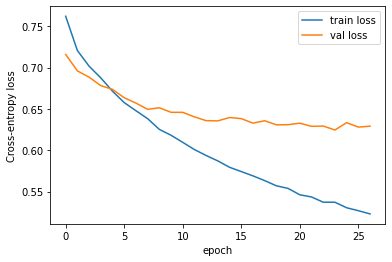

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

Plots train accuracy and validation accuracy against the number of epochs. 

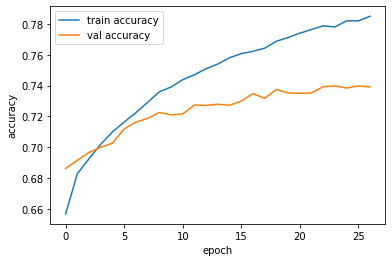

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

The below shows the loss on the left and the accuracy on the right (74% accurate in this case), which is the same as the validation data so this is a good sign. 

In [ ]:
model.evaluate(X_test, y_test)

400/400 [==============================] - 1s 2ms/step - loss: 0.6423 - accuracy: 0.7377


[0.6422904133796692, 0.7377266883850098]

Predictions


In [ ]:
print(test_reviews.iloc[0])

For those who like a bit more flavor than the soft breakfast blends -- this is the best of the bunch.  I have worked through most brand "bolds" and come back to this one every time.  Black Tiger is similar but does not have some of the added flavor notes found here.


In [ ]:
print(y_test[0])

[0. 0. 1.]


81% certain the review is positive

In [ ]:
y_pred1 = model.predict(X_test[:1])
print(y_pred1)

[[0.04325842 0.1466042  0.8101374 ]]


79% sure the reviews is negative 

In [ ]:
y_pred2 = model.predict(X_test[1:2])
print(y_pred2)
print(test_reviews.iloc[1])

[[0.7851091  0.21159744 0.00329349]]
These were kind of expensive for a dog treat and two of my dogs wouldn't even touch them, so I doubt I would buy them again.


75% sure review is average

In [ ]:
y_pred3 = model.predict(X_test[2:3])
print(y_pred3)
print(test_reviews.iloc[2])

[[0.18705404 0.7466099  0.06633607]]
I bought this flavor along with two others and was surprised at how different the texture was compared to Chick Chick and Super Salmon. It is so thick that my daughter grabs it out of her mouth after putting a bite in, which usually leads to a big mess. I now have to modify the texture by adding water to it, which does not make it a convenient food item when on the go. Since the pouches don't reseal this is even harder when traveling.<br /><br />Overall, the flavor seems good, just too thick. I still love the pouch design for the most part, since I can sometimes break the glass jars of other brands. I will just need to remember to pack some sandwich baggies in case it not working out when trying to eat it on the go.


Save the model

In [ ]:
model.save("AmazonModel.h5")